<a href="https://colab.research.google.com/github/ChirathiSomadasa/Deep_Learning_Assignment/blob/Dilhara-U.G.T---2/Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Disease Classification**


## **Somadasa N.M.C.U. - IT22354242**

### Transfer Learning Specialist — MobileNetV2

In [ ]:
# STEP 1: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip
!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
# STEP 2: Fix folder structure if nested
import os
import shutil

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)

# STEP 3: Create smaller dataset for fast demo (200 images/class)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# STEP 4: DATA PREPROCESSING — USE MOBILENETV2-SPECIFIC PREPROCESSING
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # CRITICAL

# Use preprocess_input instead of rescale=1./255
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2-specific preprocessing
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    fast_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    fast_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print(f"Training samples: {train_data.samples}, Validation samples: {val_data.samples}")
print("Classes:", train_data.class_indices)


Found 2362 images belonging to 16 classes.
Found 589 images belonging to 16 classes.
Training samples: 2362, Validation samples: 589
Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14, 'plantvillage': 15}


In [ ]:
# STEP 5: BUILD MOBILENETV2 MODEL — STAGE 1
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all base layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile for Stage 1 training
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Stage 1
early_stop_stage1 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# STEP 6: TRAIN STAGE 1 — TRAIN HEAD ONLY
print("\n=== STAGE 1: Training Head (Base Frozen) ===")
history_stage1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stop_stage1]
)

# STEP 7: FINE-TUNING STAGE 2 — UNFREEZE TOP LAYERS + LOW LR
print("\n=== STAGE 2: Fine-Tuning Top Layers ===")

# Unfreeze top 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with LOW learning rate (critical for fine-tuning)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10x smaller!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add ReduceLROnPlateau for better convergence
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
early_stop_stage2 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train for additional epochs
history_stage2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop_stage2, lr_scheduler]
)

# STEP 8: EVALUATE MODEL — AFTER FULL TRAINING (STAGE 1 + STAGE 2)
print("\n=== FINAL MODEL EVALUATION ===")
final_loss, final_acc = model.evaluate(val_data)
print(f"FINAL Validation Accuracy after Fine-Tuning: {final_acc:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== STAGE 1: Training Head (Base Frozen) ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 59s 698ms/step - accuracy: 0.2995 - loss: 2.2591 - val_accuracy: 0.6978 - val_loss: 0.9295
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 755ms/step - accuracy: 0.6760 - loss: 1.0147 - val_accuracy: 0.7929 - val_loss: 0.7238
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 688ms/step - accuracy: 0.7721 - loss: 0.7274 - val_accuracy: 0.7963 - val_loss: 0.6217
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 53s 712ms/step - accuracy: 0.7779 - loss: 0.6465 - val_accuracy: 0.8234 - val_loss: 0.5442
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 674ms/step - accuracy: 0.8057 - loss: 0.5825 - val_accuracy: 0.8285 - val_loss: 0.5682

=== STAGE 2: Fine-Tuning Top Layers ===
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 80s 918ms/step - accuracy: 0.6331 - loss: 1.2216 - val_accuracy: 0.5874 - val_loss: 1.5324 - learning_rate: 1.0000e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 69s 937ms/step - accuracy: 0.8355 - loss: 0.4910 - val_accuracy: 0.6163 - val_loss: 1.3223 - learning_rate: 1.0000e-04
Epoch

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


# Path to your test image

img_path = "/content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"

# Load & preprocess image

img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # rescale

# Predict

pred = model.predict(img_array)
class_index = np.argmax(pred, axis=1)[0]

# Map prediction to class label

# Make sure to invert the class_indices dict
class_labels = {v: k for k, v in train_data.class_indices.items()}
predicted_label = class_labels[class_index]

print(f"Predicted Disease: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Disease: Pepper__bell___healthy


In [ ]:
# Save model

model.save("/content/mobilenetv2_plant_disease_model.keras")
print("\nModel saved to: /content/mobilenetv2_plant_disease_model.h5")



Model saved to: /content/mobilenetv2_plant_disease_model.h5


In [ ]:
# Generate classification report — FIXED
from sklearn.metrics import classification_report
import numpy as np

# Reset and get predictions
val_data.reset()
y_true = val_data.classes
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes present in validation set
unique_labels = np.unique(y_true)

# Map to class names (only for classes that appear)
class_indices = val_data.class_indices  # e.g., {'class0': 0, 'class1': 1, ...}
idx_to_class = {v: k for k, v in class_indices.items()}

# Create target_names in the correct order (0 to max label)
max_label = max(unique_labels)
target_names_filtered = [idx_to_class[i] for i in range(max_label + 1) if i in unique_labels]

# Generate report
report = classification_report(
    y_true,
    y_pred_classes,
    labels=unique_labels,
    target_names=target_names_filtered,
    zero_division=0
)

print(report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 584ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.03      0.03      0.03        40
                     Pepper__bell___healthy       0.09      0.10      0.10        40
                      Potato___Early_blight       0.10      0.10      0.10        40
                       Potato___Late_blight       0.02      0.03      0.02        40
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.00      0.00      0.00        40
                        Tomato_Early_blight       0.06      0.03      0.04        40
                         Tomato_Late_blight       0.04      0.05      0.04        40
                           Tomato_Leaf_Mold       0.08      0.07      0.08        40
                  Tomato_Septoria_leaf_spot       0.06      0.05      0.05        40
Tomato_Spider_mites_Tw

In [ ]:

# Get a sample batch from validation data
val_data.reset()
sample_batch, _ = next(val_data)  # Gets one batch (e.g., 32 images)
print(f"Sample batch shape: {sample_batch.shape}")
# Parameters
print(f"Parameters: {model.count_params():,}")

# Inference time (as shown earlier)
import time
start = time.time()
_ = model.predict(sample_batch, verbose=0)
inference_time = (time.time() - start) / len(sample_batch) * 1000  # ms per image

Sample batch shape: (32, 128, 128, 3)
Parameters: 2,424,016


##**Balasooriya B.M.P.U.  -  IT22927248**

### Transfer Leaning Specialist - Custom CNN

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
# Fix folder structure if nested

import os
import shutil

In [ ]:
# Check if inner folder exists

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)

In [ ]:
# Create smaller dataset for fast demo (optional)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # reduce per class for fast execution

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Use the fast demo directory for training
data_dir = fast_dir

# Remove any empty directories
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        if len(os.listdir(class_path)) == 0:  # If folder is empty
            os.rmdir(class_path)
            print(f"Removed empty directory: {class_name}")


Removed empty directory: plantvillage


In [ ]:
# Create datasets using the modern approach
import tensorflow as tf

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)


Found 2952 files belonging to 15 classes.
Using 2362 files for training.
Found 2952 files belonging to 15 classes.
Using 590 files for validation.


In [ ]:
# Apply data augmentation to training dataset

import tensorflow as tf

def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.1)
    return image, label

# Apply augmentation only to training data
train_ds = train_ds.map(augment_images)
# Normalize both datasets
train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds = val_ds.map(lambda x, y: (x/255.0, y))

# Optimize performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Training samples: {len(train_ds) * batch_size}")
print(f"Validation samples: {len(val_ds) * batch_size}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")


Training samples: 2368
Validation samples: 608
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# Design the custom CNN architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Create the model
model = Sequential([
    # Input layer
    Input(shape=(128, 128, 3)),

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Fourth convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.2429 - loss: 2.9632 - val_accuracy: 0.0593 - val_loss: 19.1862 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4549 - loss: 1.7416 - val_accuracy: 0.0593 - val_loss: 23.5493 - learning_rate: 0.0010
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5681 - loss: 1.4071 - val_accuracy: 0.0593 - val_loss: 24.7613 - learning_rate: 0.0010
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6147 - loss: 1.1443 - val_accuracy: 0.0644 - val_loss: 17.8341 - learning_rate: 0.0010
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.6657 - loss: 0.9975 - val_accuracy: 0.1186 - val_loss: 10.9894 - learning_rate: 0.0010
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6934 - loss: 0.9175 - val_accuracy: 0.1661 - val_loss: 7.4885 - learning_rate: 0.0010
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7492 - loss: 0.7760 - va

In [ ]:
# Evaluate the model

test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.8195 - loss: 0.6441
Validation Accuracy: 80.51%


In [ ]:
# 9. Predictions + classification report

import numpy as np
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.85      0.83      0.84        41
                     Pepper__bell___healthy       1.00      0.77      0.87        39
                      Potato___Early_blight       0.93      0.91      0.92        43
                       Potato___Late_blight       0.59      0.89      0.71        38
                           Potato___healthy       0.97      0.91      0.94        35
                      Tomato_Bacterial_spot       0.53      1.00      0.69        33
                        Tomato_Early_blight       0.67      0.42      0.52        38
                         Tomato_Late_blight       0.79      0.64      0.71        47
                           Tomato_Leaf_Mold       0.81      0.76      0.78        33
                  Tomato_Septoria_leaf_spot       0.84      0.58      0.69        36
Tomato_Spider_mites_Two_spotted_spider_mite       0.73      0.88

In [ ]:
# Model save:

model.save('custom_cnn_plant_disease.keras')
print("Model saved as 'custom_cnn_plant_disease.keras'")

Model saved as 'custom_cnn_plant_disease.keras'


In [ ]:
# Function to predict on new images

def predict_disease(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    return class_names[predicted_class], confidence

In [ ]:
# Test the prediction function with a sample image_1

sample_image_path = "/content/PlantVillage/Tomato_Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Disease: Tomato_Bacterial_spot with confidence: 1.00


In [ ]:
# Test the prediction function with a sample image_2

sample_image_path = "/content/PlantVillage/Tomato__Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Disease: Tomato__Tomato_mosaic_virus with confidence: 0.99


## **Chandrasoma M.H.R - IT22347412**

### Smart Plant Disease Classifier - EfficientNetB0

In [ ]:
# STEP 1: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
#Fix folder structure if nested

import os, shutil

In [ ]:
# Check if inner folder exists

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)
print("Folder structure fixed!")

Folder structure fixed!


In [ ]:
# STEP 3: Create smaller dataset for fast demo (optional)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # limit per class for faster runs

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Remove empty dirs if any
for class_name in os.listdir(fast_dir):
    class_path = os.path.join(fast_dir, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)
        print(f"Removed empty directory: {class_name}")

print("Fast demo dataset created at:", fast_dir)

# Use fast dataset
data_dir = fast_dir

Removed empty directory: plantvillage
Fast demo dataset created at: /content/PlantVillage_FastDemo


In [ ]:
# STEP 4: Data Preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"Number of classes detected: {NUM_CLASSES}")

Found 2362 images belonging to 15 classes.
Found 590 images belonging to 15 classes.
Number of classes detected: 15


In [ ]:
# STEP 5: Model Development (EfficientNetB0 + Custom Head)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze for Phase 1

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output, name="smart_plant_disease_classifier")

print("Model Summary:")
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary:


Model: "smart_plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# STEP 6: Training Phase 1 (Feature Extraction)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5
)

# Plot Phase 1 Metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.title("Smart Plant Disease Classifier - Phase 1 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Smart Plant Disease Classifier - Phase 1 Loss")
plt.legend()
plt.show()


In [ ]:
# STEP 7: Training Phase 2 (Fine-Tuning)
# Unfreeze last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5
)

# Plot Phase 2 Metrics
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Smart Plant Disease Classifier - Phase 2 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Smart Plant Disease Classifier - Phase 2 Loss")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.0599 - loss: 2.7459 - val_accuracy: 0.0678 - val_loss: 2.7385
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.0636 - loss: 2.7430 - val_accuracy: 0.0678 - val_loss: 2.7346
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.0752 - loss: 2.7291 - val_accuracy: 0.0678 - val_loss: 2.7275
Epoch 4/5
11/74 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.0908 - loss: 2.7450

In [ ]:
# STEP 8: Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate final model
val_loss, val_acc = model.evaluate(valid_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Predictions
y_true = valid_generator.classes
y_pred = np.argmax(model.predict(valid_generator), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Smart Plant Disease Classifier - Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(valid_generator.class_indices.keys())))


In [ ]:
# STEP 9: Save Model
model.save("smart_plant_disease_classifier.keras")
print("Model saved as smart_plant_disease_classifier.keras")

## **Dilhara U.G.T - IT22309624**

### Plant Disease Classification using Deep Learning - Vision Transformer (ViT) Pioneer

#### Initionating the model

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/Colab Notebooks/DL Assignment/archive.zip" -d "/content/PlantVillage"

In [ ]:
# Fix folder structure if nested

import os
import shutil


# Check if inner folder exists

# Define the expected path to the unzipped dataset
dataset_path = '/content/PlantVillage'

# Check if a common inner folder exists ('PlantVillage')
inner_folder_name = 'PlantVillage'
inner_folder_path = os.path.join(dataset_path, inner_folder_name)

if os.path.exists(inner_folder_path) and os.path.isdir(inner_folder_path):
    print(f"Inner folder '{inner_folder_name}' found at: {inner_folder_path} \n")
    # List contents of the inner folder
    print("Contents of the inner folder: \n")
    for item in os.listdir(inner_folder_path):
        print(item)
else:
    print(f"Inner folder '{inner_folder_name}' not found at: {inner_folder_path}")
    # If the common inner folder is not found, list the contents of the main dataset directory
    print(f"Contents of the main dataset directory ({dataset_path}):")
    for item in os.listdir(dataset_path):
        print(item)


Inner folder 'PlantVillage' found at: /content/PlantVillage/PlantVillage 

Contents of the inner folder: 

Pepper__bell___Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_healthy
Tomato_Early_blight
Tomato_Late_blight
Tomato_Leaf_Mold
Tomato_Bacterial_spot
Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Early_blight
Pepper__bell___healthy
Tomato__Target_Spot
Tomato__Tomato_mosaic_virus
Potato___healthy
Potato___Late_blight


In [ ]:
# Create smaller dataset for fast demo (optional)

original_dir = "/content/PlantVillage/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # limit per class for faster runs

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Remove empty dirs if any
for class_name in os.listdir(fast_dir):
    class_path = os.path.join(fast_dir, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)
        print(f"Removed empty directory: {class_name}")

print("Fast demo dataset created at:", fast_dir)

# Use fast dataset
data_dir = fast_dir

Fast demo dataset created at: /content/PlantVillage_FastDemo


In [ ]:
# Data Preprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "/content/PlantVillage/PlantVillage"
IMG_SIZE = 224  # Typical for ViT
BATCH_SIZE = 32
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Number of classes detected: {NUM_CLASSES}")
print("Classes:", class_names)

# Rescale the datasets
def rescale_images(image, label):
    image = image / 255.0
    return image, label

train_ds = train_ds.map(rescale_images)
val_ds = val_ds.map(rescale_images)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1), # Corresponds to rotation_range=20 (approx 0.1 rad)
    tf.keras.layers.RandomZoom(0.2, 0.2), # Corresponds to zoom_range=0.2
])

# Apply augmentation only to training data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 2951 files belonging to 15 classes.
Using 2361 files for training.
Found 2951 files belonging to 15 classes.
Using 590 files for validation.
Number of classes detected: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


#### Model Development

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, callbacks, optimizers

IMG_SIZE = 224
NUM_CLASSES = 15


# Load a pre-trained ViT model from TensorFlow Hub ( ViT-B/16)
# URL: https://tfhub.dev/sayakpaul/vit_b16_fe/1 (feature extractor, no classification head)
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"

vit_layer = hub.KerasLayer(
    vit_url,
    trainable=False  # freeze for Phase 1
)


# Model definition
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)  # normalize input
x = layers.Lambda(lambda t: vit_layer(t))(x)       # ViT feature extractor
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

vit_model = models.Model(inputs=inputs, outputs=outputs, name="smart_plant_disease_classifier")

print("Model Summary:")
vit_model.summary()


Model Summary:


Model: "smart_plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,471 (1.54 MB)

 Trainable params: 402,447 (1.54 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Compile
vit_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_learning_rate=1e-5
)


# Train model
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate model

loss, acc = vit_model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}")

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2107s 28s/step - accuracy: 0.1484 - loss: 2.6489 - val_accuracy: 0.0610 - val_loss: 3.2036 - learning_rate: 0.0010
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2020s 27s/step - accuracy: 0.2568 - loss: 2.2833 - val_accuracy: 0.0831 - val_loss: 4.6160 - learning_rate: 0.0010
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2019s 27s/step - accuracy: 0.2881 - loss: 2.1877 - val_accuracy: 0.0763 - val_loss: 4.1420 - learning_rate: 0.0010
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1949s 26s/step - accuracy: 0.3182 - loss: 2.1169 - val_accuracy: 0.0661 - val_loss: 3.7833 - learning_rate: 0.0010
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1969s 27s/step - accuracy: 0.3317 - loss: 2.0314 - val_accuracy: 0.0712 - val_loss: 5.6800 - learning_rate: 0.0010
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1976s 26s/step - accuracy: 0.3643 - loss: 1.9748 - val_accuracy: 0.1254 - val_loss: 6.1913 - learning_rate: 0.0010
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2012s 27s/step - accuracy: 0.3584 - loss: 1.

In [ ]:
# 1. Unfreeze the ViT layer for fine-tuning
vit_layer.trainable = True

# 2. Re-compile with lower learning rate for fine-tuning
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR!
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 3. (Optional but recommended) Re-enable callbacks
early_stop_finetune = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce_lr_finetune = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.5,
    min_learning_rate=1e-6
)

# 4. Fine-tune (train) for a few more epochs
history_finetune = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # for fine-tuning
    callbacks=[early_stop_finetune, reduce_lr_finetune],
    verbose=1
)


# 5. Evaluate model
loss, acc = vit_model.evaluate(val_ds)
print(f"Validation Accuracy after fine-tune: {acc:.4f}")
print(f"Validation Accuracy after fine-tune: {acc * 100:.2f}%")

Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 1978s 27s/step - accuracy: 0.2761 - loss: 2.2502 - val_accuracy: 0.1051 - val_loss: 2.7441 - learning_rate: 1.0000e-04
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 1968s 27s/step - accuracy: 0.2845 - loss: 2.1973 - val_accuracy: 0.1153 - val_loss: 2.6059 - learning_rate: 1.0000e-04
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2029s 27s/step - accuracy: 0.2875 - loss: 2.1876 - val_accuracy: 0.1763 - val_loss: 2.6240 - learning_rate: 1.0000e-04
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2014s 27s/step - accuracy: 0.2985 - loss: 2.1590 - val_accuracy: 0.1983 - val_loss: 2.7179 - learning_rate: 1.0000e-04
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2027s 27s/step - accuracy: 0.3058 - loss: 2.1336 - val_accuracy: 0.1458 - val_loss: 2.8897 - learning_rate: 1.0000e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 387s 20s/step - accuracy: 0.1184 - loss: 2.6083
Validation Accuracy after fine-tune: 0.1153
Validation Accuracy after fine-tune: 11.53%


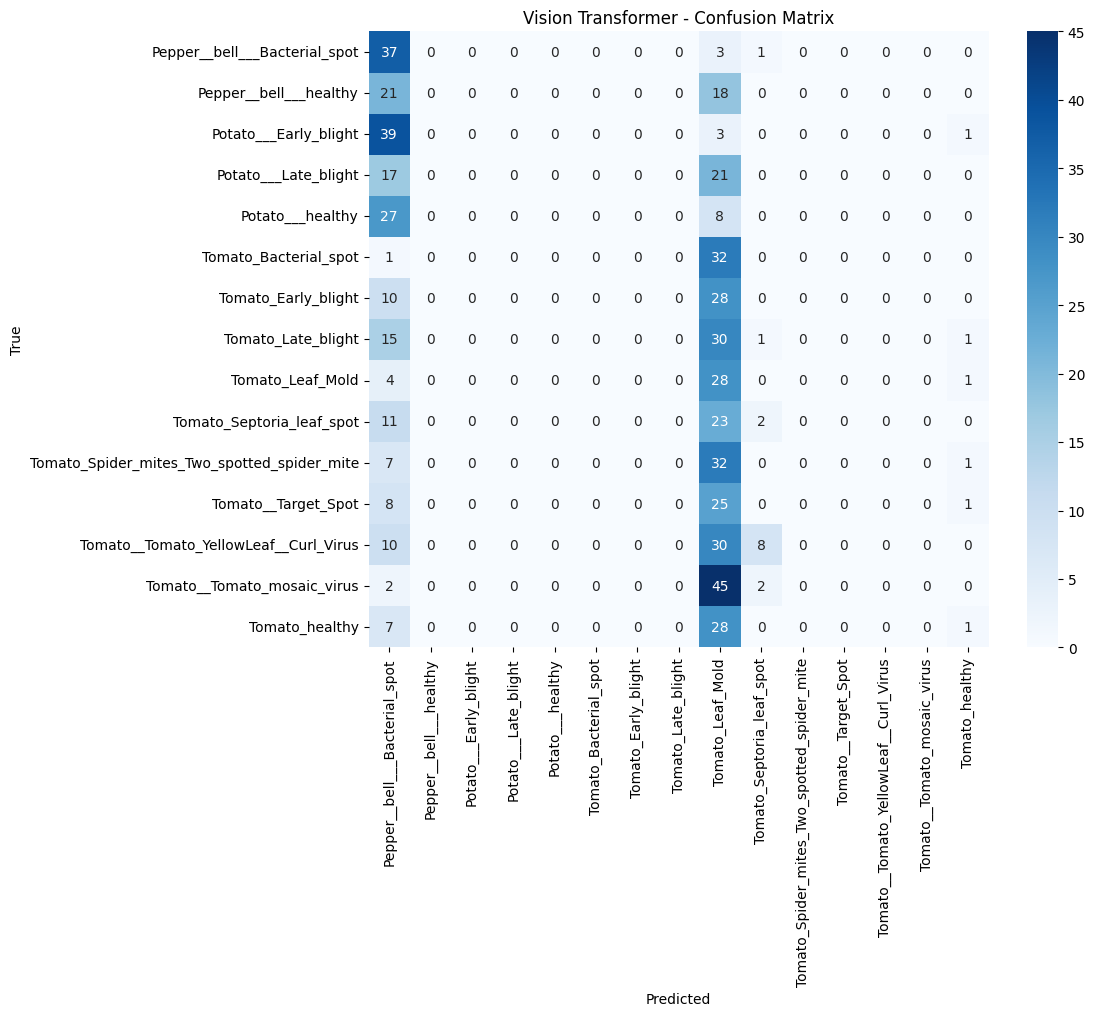

Classification Report for Vision Transformer Model:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.17      0.90      0.29        41
                     Pepper__bell___healthy       0.00      0.00      0.00        39
                      Potato___Early_blight       0.00      0.00      0.00        43
                       Potato___Late_blight       0.00      0.00      0.00        38
                           Potato___healthy       0.00      0.00      0.00        35
                      Tomato_Bacterial_spot       0.00      0.00      0.00        33
                        Tomato_Early_blight       0.00      0.00      0.00        38
                         Tomato_Late_blight       0.00      0.00      0.00        47
                           Tomato_Leaf_Mold       0.08      0.85      0.14        33
                  Tomato_Septoria_leaf_spot       0.14      0.06      0.08        36
Tomato_Spide

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = vit_model.predict(images, verbose=0)
    # If labels are integer class indices:
    y_true.extend(labels.numpy())  # No argmax needed
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vision Transformer - Confusion Matrix')
plt.show()

# 3. Classification Report
print("Classification Report for Vision Transformer Model:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# 4. Overall Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print(f"Overall Validation Accuracy: {acc:.4f}")
print(f"Overall Validation Accuracy: {acc * 100:.2f}%")

In [ ]:
# Save the entire model (architecture + weights + training config)
vit_model.save("smart_plant_disease_classifier_vit_finetuned_model.keras")
print("Model saved as smart_plant_disease_classifier_vit_finetuned_model.keras")

Model saved as smart_plant_disease_classifier_vit_finetuned_model.keras
